<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/vito/STEP_5_BISENET_ADV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [1]:
!pip install torchmetrics
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:
from google.colab import drive
import os

!git clone -b angelo_albumentations --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git

!cp AML_2025_project4/utils.py .

drive.mount('/content/drive')

Cloning into 'AML_2025_project4'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 124 (delta 18), reused 6 (delta 6), pack-reused 88 (from 1)
Receiving objects: 100% (124/124), 21.14 MiB | 21.69 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Mounted at /content/drive


In [3]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [4]:
import tqdm

from utils import get_loveDA

paths = get_loveDA(verbose=True)
print(paths)

TRAINING_PATH_URBAN = paths["training_urban"]
TRAINING_PATH_RURAL = paths["training_rural"]
VAL_PATH_URBAN = paths["validation_urban"]
VAL_PATH_RURAL = paths["validation_rural"]

Extracting training...
training extracted!
Extracting validation...
validation extracted!
Extraction check completed!
{'training_urban': '/content/dataset/Train/Urban', 'training_rural': '/content/dataset/Train/Rural', 'validation_urban': '/content/dataset/Val/Urban', 'validation_rural': '/content/dataset/Val/Rural'}


In [5]:
SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

IGNORE_INDEX = -1

RESIZE = 512

BATCH_SIZE = 16

EPOCHS = 20

SEED = 42

STEP_SIZE = 21

GAMMA = 0.5

LR = 0.00053
LR_D = 0.0000027
LAMBDA_ADV_TARGET = 0.0074
LAMBDA_SEG = 0.45
P = 0.5 # probabilità augmentation


# Define networks

### Define BiSeNet

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as modelzoo

backbone_url = 'https://github.com/CoinCheung/BiSeNet/releases/download/0.0.0/backbone_v2.pth'


class ConvBNReLU(nn.Module):

    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1,
                 dilation=1, groups=1, bias=False):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(
                in_chan, out_chan, kernel_size=ks, stride=stride,
                padding=padding, dilation=dilation,
                groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        feat = self.conv(x)
        feat = self.bn(feat)
        feat = self.relu(feat)
        return feat


class UpSample(nn.Module):

    def __init__(self, n_chan, factor=2):
        super(UpSample, self).__init__()
        out_chan = n_chan * factor * factor
        self.proj = nn.Conv2d(n_chan, out_chan, 1, 1, 0)
        self.up = nn.PixelShuffle(factor)
        self.init_weight()

    def forward(self, x):
        feat = self.proj(x)
        feat = self.up(feat)
        return feat

    def init_weight(self):
        nn.init.xavier_normal_(self.proj.weight, gain=1.)



class DetailBranch(nn.Module):

    def __init__(self):
        super(DetailBranch, self).__init__()
        self.S1 = nn.Sequential(
            ConvBNReLU(3, 64, 3, stride=2),
            ConvBNReLU(64, 64, 3, stride=1),
        )
        self.S2 = nn.Sequential(
            ConvBNReLU(64, 64, 3, stride=2),
            ConvBNReLU(64, 64, 3, stride=1),
            ConvBNReLU(64, 64, 3, stride=1),
        )
        self.S3 = nn.Sequential(
            ConvBNReLU(64, 128, 3, stride=2),
            ConvBNReLU(128, 128, 3, stride=1),
            ConvBNReLU(128, 128, 3, stride=1),
        )

    def forward(self, x):
        feat = self.S1(x)
        feat = self.S2(feat)
        feat = self.S3(feat)
        return feat


class StemBlock(nn.Module):

    def __init__(self):
        super(StemBlock, self).__init__()
        self.conv = ConvBNReLU(3, 16, 3, stride=2)
        self.left = nn.Sequential(
            ConvBNReLU(16, 8, 1, stride=1, padding=0),
            ConvBNReLU(8, 16, 3, stride=2),
        )
        self.right = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=1, ceil_mode=False)
        self.fuse = ConvBNReLU(32, 16, 3, stride=1)

    def forward(self, x):
        feat = self.conv(x)
        feat_left = self.left(feat)
        feat_right = self.right(feat)
        feat = torch.cat([feat_left, feat_right], dim=1)
        feat = self.fuse(feat)
        return feat


class CEBlock(nn.Module):

    def __init__(self):
        super(CEBlock, self).__init__()
        self.bn = nn.BatchNorm2d(128)
        self.conv_gap = ConvBNReLU(128, 128, 1, stride=1, padding=0)
        #TODO: in paper here is naive conv2d, no bn-relu
        self.conv_last = ConvBNReLU(128, 128, 3, stride=1)

    def forward(self, x):
        feat = torch.mean(x, dim=(2, 3), keepdim=True)
        feat = self.bn(feat)
        feat = self.conv_gap(feat)
        feat = feat + x
        feat = self.conv_last(feat)
        return feat


class GELayerS1(nn.Module):

    def __init__(self, in_chan, out_chan, exp_ratio=6):
        super(GELayerS1, self).__init__()
        mid_chan = in_chan * exp_ratio
        self.conv1 = ConvBNReLU(in_chan, in_chan, 3, stride=1)
        self.dwconv = nn.Sequential(
            nn.Conv2d(
                in_chan, mid_chan, kernel_size=3, stride=1,
                padding=1, groups=in_chan, bias=False),
            nn.BatchNorm2d(mid_chan),
            nn.ReLU(inplace=True), # not shown in paper
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                mid_chan, out_chan, kernel_size=1, stride=1,
                padding=0, bias=False),
            nn.BatchNorm2d(out_chan),
        )
        self.conv2[1].last_bn = True
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.dwconv(feat)
        feat = self.conv2(feat)
        feat = feat + x
        feat = self.relu(feat)
        return feat


class GELayerS2(nn.Module):

    def __init__(self, in_chan, out_chan, exp_ratio=6):
        super(GELayerS2, self).__init__()
        mid_chan = in_chan * exp_ratio
        self.conv1 = ConvBNReLU(in_chan, in_chan, 3, stride=1)
        self.dwconv1 = nn.Sequential(
            nn.Conv2d(
                in_chan, mid_chan, kernel_size=3, stride=2,
                padding=1, groups=in_chan, bias=False),
            nn.BatchNorm2d(mid_chan),
        )
        self.dwconv2 = nn.Sequential(
            nn.Conv2d(
                mid_chan, mid_chan, kernel_size=3, stride=1,
                padding=1, groups=mid_chan, bias=False),
            nn.BatchNorm2d(mid_chan),
            nn.ReLU(inplace=True), # not shown in paper
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                mid_chan, out_chan, kernel_size=1, stride=1,
                padding=0, bias=False),
            nn.BatchNorm2d(out_chan),
        )
        self.conv2[1].last_bn = True
        self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_chan, in_chan, kernel_size=3, stride=2,
                    padding=1, groups=in_chan, bias=False),
                nn.BatchNorm2d(in_chan),
                nn.Conv2d(
                    in_chan, out_chan, kernel_size=1, stride=1,
                    padding=0, bias=False),
                nn.BatchNorm2d(out_chan),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.dwconv1(feat)
        feat = self.dwconv2(feat)
        feat = self.conv2(feat)
        shortcut = self.shortcut(x)
        feat = feat + shortcut
        feat = self.relu(feat)
        return feat


class SegmentBranch(nn.Module):

    def __init__(self):
        super(SegmentBranch, self).__init__()
        self.S1S2 = StemBlock()
        self.S3 = nn.Sequential(
            GELayerS2(16, 32),
            GELayerS1(32, 32),
        )
        self.S4 = nn.Sequential(
            GELayerS2(32, 64),
            GELayerS1(64, 64),
        )
        self.S5_4 = nn.Sequential(
            GELayerS2(64, 128),
            GELayerS1(128, 128),
            GELayerS1(128, 128),
            GELayerS1(128, 128),
        )
        self.S5_5 = CEBlock()

    def forward(self, x):
        feat2 = self.S1S2(x)
        feat3 = self.S3(feat2)
        feat4 = self.S4(feat3)
        feat5_4 = self.S5_4(feat4)
        feat5_5 = self.S5_5(feat5_4)
        return feat2, feat3, feat4, feat5_4, feat5_5


class BGALayer(nn.Module):

    def __init__(self):
        super(BGALayer, self).__init__()
        self.left1 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, groups=128, bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                128, 128, kernel_size=1, stride=1,
                padding=0, bias=False),
        )
        self.left2 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=2,
                padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
        )
        self.right1 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, bias=False),
            nn.BatchNorm2d(128),
        )
        self.right2 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, groups=128, bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                128, 128, kernel_size=1, stride=1,
                padding=0, bias=False),
        )
        self.up1 = nn.Upsample(scale_factor=4)
        self.up2 = nn.Upsample(scale_factor=4)
        ##TODO: does this really has no relu?
        self.conv = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), # not shown in paper
        )

    def forward(self, x_d, x_s):
        dsize = x_d.size()[2:]
        left1 = self.left1(x_d)
        left2 = self.left2(x_d)
        right1 = self.right1(x_s)
        right2 = self.right2(x_s)
        right1 = self.up1(right1)
        left = left1 * torch.sigmoid(right1)
        right = left2 * torch.sigmoid(right2)
        right = self.up2(right)
        out = self.conv(left + right)
        return out



class SegmentHead(nn.Module):

    def __init__(self, in_chan, mid_chan, n_classes, up_factor=8, aux=True):
        super(SegmentHead, self).__init__()
        self.conv = ConvBNReLU(in_chan, mid_chan, 3, stride=1)
        self.drop = nn.Dropout(0.1)
        self.up_factor = up_factor

        out_chan = n_classes
        mid_chan2 = up_factor * up_factor if aux else mid_chan
        up_factor = up_factor // 2 if aux else up_factor
        self.conv_out = nn.Sequential(
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                ConvBNReLU(mid_chan, mid_chan2, 3, stride=1)
                ) if aux else nn.Identity(),
            nn.Conv2d(mid_chan2, out_chan, 1, 1, 0, bias=True),
            nn.Upsample(scale_factor=up_factor, mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        feat = self.conv(x)
        feat = self.drop(feat)
        feat = self.conv_out(feat)
        return feat


class CustomArgMax(torch.autograd.Function):

    @staticmethod
    def forward(ctx, feat_out, dim):
        return feat_out.argmax(dim=dim).int()

    @staticmethod
    def symbolic(g, feat_out, dim: int):
        return g.op('CustomArgMax', feat_out, dim_i=dim)


class BiSeNetV2(nn.Module):

    def __init__(self, n_classes, aux_mode='train'):
        super(BiSeNetV2, self).__init__()
        self.aux_mode = aux_mode
        self.detail = DetailBranch()
        self.segment = SegmentBranch()
        self.bga = BGALayer()

        ## TODO: what is the number of mid chan ?
        self.head = SegmentHead(128, 1024, n_classes, up_factor=8, aux=False)
        if self.aux_mode == 'train':
            self.aux2 = SegmentHead(16, 128, n_classes, up_factor=4)
            self.aux3 = SegmentHead(32, 128, n_classes, up_factor=8)
            self.aux4 = SegmentHead(64, 128, n_classes, up_factor=16)
            self.aux5_4 = SegmentHead(128, 128, n_classes, up_factor=32)

        self.init_weights()

    def forward(self, x):
        size = x.size()[2:]
        feat_d = self.detail(x)
        feat2, feat3, feat4, feat5_4, feat_s = self.segment(x)
        feat_head = self.bga(feat_d, feat_s)

        logits = self.head(feat_head)
        if self.aux_mode == 'train':
            logits_aux2 = self.aux2(feat2)
            logits_aux3 = self.aux3(feat3)
            logits_aux4 = self.aux4(feat4)
            logits_aux5_4 = self.aux5_4(feat5_4)
            return logits, logits_aux2, logits_aux3, logits_aux4, logits_aux5_4
        elif self.aux_mode == 'eval':
            return logits,
        elif self.aux_mode == 'pred':
            #  pred = logits.argmax(dim=1)
            pred = CustomArgMax.apply(logits, 1)
            return pred
        else:
            raise NotImplementedError

    def init_weights(self):
        for name, module in self.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(module.weight, mode='fan_out')
                if not module.bias is None: nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.modules.batchnorm._BatchNorm):
                if hasattr(module, 'last_bn') and module.last_bn:
                    nn.init.zeros_(module.weight)
                else:
                    nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
        self.load_pretrain()


    def load_pretrain(self):
        state = modelzoo.load_url(backbone_url)
        for name, child in self.named_children():
            if name in state.keys():
                child.load_state_dict(state[name], strict=True)

    def get_params(self):
        def add_param_to_list(mod, wd_params, nowd_params):
            for param in mod.parameters():
                if param.dim() == 1:
                    nowd_params.append(param)
                elif param.dim() == 4:
                    wd_params.append(param)
                else:
                    print(name)

        wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params = [], [], [], []
        for name, child in self.named_children():
            if 'head' in name or 'aux' in name:
                add_param_to_list(child, lr_mul_wd_params, lr_mul_nowd_params)
            else:
                add_param_to_list(child, wd_params, nowd_params)
        return wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params


## Define Discriminator
Used for the adversarial approach

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


class FCDiscriminator(nn.Module):

	def __init__(self, num_classes, ndf = 64):
		super(FCDiscriminator, self).__init__()

		self.conv1 = nn.Conv2d(num_classes, ndf, kernel_size=4, stride=2, padding=1)
		self.conv2 = nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1)
		self.conv3 = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1)
		self.conv4 = nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1)
		self.classifier = nn.Conv2d(ndf*8, 1, kernel_size=4, stride=2, padding=1)

		self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)


	def forward(self, x):
		x = self.conv1(x)
		x = self.leaky_relu(x)
		x = self.conv2(x)
		x = self.leaky_relu(x)
		x = self.conv3(x)
		x = self.leaky_relu(x)
		x = self.conv4(x)
		x = self.leaky_relu(x)
		x = self.classifier(x)

		return x

# Dataset & dataloader

## Dataset definition

In [8]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform, target=False, augmentation=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.augmentation = augmentation
        self.target = target

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Read an image with OpenCV
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)


        if self.augmentation:
          transformed = self.augmentation(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]


        mask_np = np.array(mask)

        edge = cv2.Canny(mask_np, 0.1, 0.2)

        kernel = np.ones((3, 3), np.uint8)  # Kernel for dilation

        edge = edge[6:-6, 6:-6]
        edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
        boundaries = cv2.dilate(edge, kernel, iterations=1)  # Dilate edges
        boundaries = (boundaries > 50) * 1.0 # boundaries matrix is float with 1.0 or 0.0

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        boundaries_tensor = torch.as_tensor(boundaries, dtype=torch.float32)

        # if the dataset is a target dataset, does not return the mask
        if self.target == True:
          return image, boundaries_tensor
        return image, mask, boundaries_tensor

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [9]:
# Define transformations for images & masks
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import v2 as T
import cv2

resize_transform = A.Compose([
    A.Resize(height=RESIZE, width=RESIZE, p=1),
    A.ToFloat(),
    ToTensorV2()
])

# the best augmentation from previous step is chosen
augment =  A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=P)


## Dataset instantiation

In [10]:
# Create dataset objects

# TRAINING DATASETS
source_dataset = SegmentationDataset(TRAINING_PATH_URBAN + "/images_png", TRAINING_PATH_URBAN + "/masks_png",
                                    transform=resize_transform, augmentation=augment)


target_dataset = SegmentationDataset(TRAINING_PATH_RURAL + "/images_png", TRAINING_PATH_RURAL + "/masks_png",
                                    transform=resize_transform, target=True, augmentation=augment)

# EVALUATION DATASET

val_dataset = SegmentationDataset(VAL_PATH_RURAL + "/images_png", VAL_PATH_RURAL + "/masks_png",
                                    transform=resize_transform)

## Loader instantiation

In [11]:
# Create DataLoaders

# TRAINING DATALOADERS
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# EVALUATION DATALOADERS

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# enumerate dataloaders
source_loader_iter = enumerate(source_loader)
target_loader_iter = enumerate(target_loader)


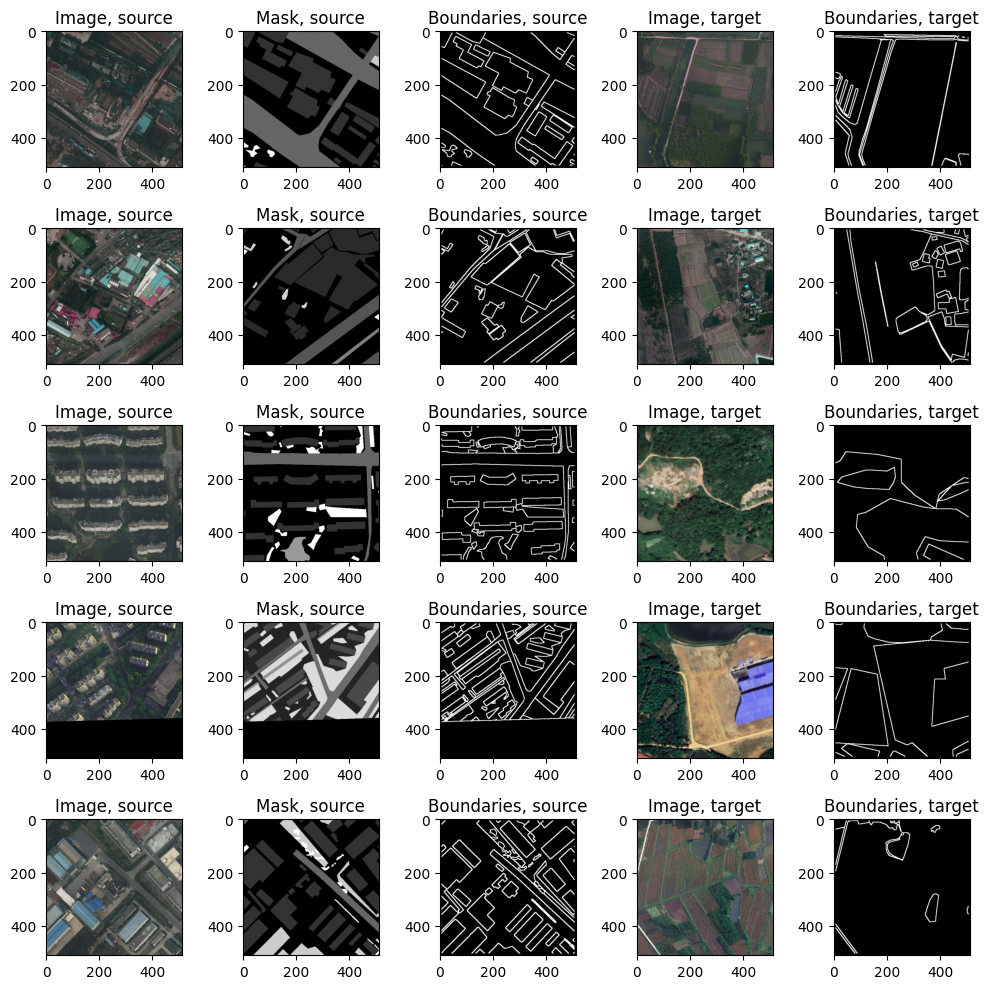

In [12]:
from utils import show
from matplotlib import pyplot as plt

source_batch = next(iter(source_loader))  # (images, masks, boundaries)
target_batch = next(iter(target_loader))  # (images, masks, boundaries)
images_s, masks_s, boundaries_s = source_batch  # Unpack the source batch
images_t, boundaries_t = target_batch  # Unpack the target batch

fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # 3 images, each with RGB, mask, and boundary

for i in range(5):  # Show first 3 images

    # VISUALIZE SOURCE SAMPLES
    # Permute the dimensions of the image tensor to (height, width, channels)
    image_s_np = images_s[i].cpu().numpy().transpose(1, 2, 0)

    axes[i, 0].imshow(image_s_np) # Display the image with the correct shape
    axes[i, 0].set_title("Image, source")

    axes[i, 1].imshow(masks_s[i].cpu().numpy(), cmap="gray")  # Show mask
    axes[i, 1].set_title("Mask, source")

    axes[i, 2].imshow(boundaries_s[i].cpu().numpy(), cmap="gray")  # Show boundaries
    axes[i, 2].set_title("Boundaries, source")

    # VISUALIZE TARGET SAMPLES
    image_t_np = images_t[i].cpu().numpy().transpose(1, 2, 0)
    axes[i, 3].imshow(image_t_np) # Display the image with the correct shape
    axes[i, 3].set_title("Image, target")

    axes[i, 4].imshow(boundaries_t[i].cpu().numpy(), cmap="gray")  # Show boundaries
    axes[i, 4].set_title("Boundaries, target")


plt.tight_layout()
plt.show()

# Instantiate model

In [13]:
model = BiSeNetV2(NUM_CLASSES)

Downloading: "https://github.com/CoinCheung/BiSeNet/releases/download/0.0.0/backbone_v2.pth" to /root/.cache/torch/hub/checkpoints/backbone_v2.pth
100%|██████████| 8.34M/8.34M [00:00<00:00, 139MB/s]


## Define loss functions

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class OhemCELoss(nn.Module):

    def __init__(self, thresh, lb_ignore=255):
        super(OhemCELoss, self).__init__()
        self.thresh = -torch.log(torch.tensor(thresh, requires_grad=False, dtype=torch.float)).cuda()
        self.lb_ignore = lb_ignore
        self.criteria = nn.CrossEntropyLoss(ignore_index=lb_ignore, reduction='none')

    def forward(self, logits, labels):
        n_min = labels[labels != self.lb_ignore].numel() // 16
        loss = self.criteria(logits, labels).view(-1)
        loss_hard = loss[loss > self.thresh]
        if loss_hard.numel() < n_min:
            loss_hard, _ = loss.topk(n_min)
        return torch.mean(loss_hard)

class CrossEntropyLoss2dPixelWiseWeighted(nn.Module):
    def __init__(self, weight=None, ignore_index=250, reduction='none'):
        super(CrossEntropyLoss2dPixelWiseWeighted, self).__init__()
        self.CE =  nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index, reduction=reduction)

    def forward(self, output, target, pixelWiseWeight):
        loss = self.CE(output, target)
        loss = torch.mean(loss * pixelWiseWeight)
        return loss

## Upscaling function

In [15]:
import torch.nn.functional as F

def Upscaling(outputs, boundary_mask, model):
    """Upscale trough bilinear interpolation -> riporto le dimensioni dell'output a quelli originali
    Quindi passiamo da 64 x 64 della rete a 512 x 512"""

    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)
    if model.augment:
        pred_p, pred_main, boundary_head = outputs  # P, I, D branches
    else:
        pred_p = None
        pred_main = outputs
        boundary_head = None  # Nessuna branch D se augment=False

    return pred_p, pred_main, boundary_head

# Training Phase

## Instantiate discriminator, optimizers and schedulers

In [17]:
from torch.optim.lr_scheduler import LambdaLR, SequentialLR, StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_D = FCDiscriminator(num_classes=NUM_CLASSES)
model_D.to(device)

model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LR)
optimizer_D = torch.optim.Adam(model_D.parameters(), lr=LR_D)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=GAMMA, patience=3, threshold=0.01)

bce_loss = torch.nn.BCEWithLogitsLoss()

loss_fn = OhemCELoss(thresh=0.8, lb_ignore = IGNORE_INDEX)
num_aux_heads = 4
criteria_aux = [OhemCELoss(0.8, IGNORE_INDEX) for _ in range(num_aux_heads)]

cuda


## Train

In [19]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

source_label = 0
target_label = 1

model.to(device)
model_D.to(device)

num_classes = 7
miou_classes = MeanIoU(num_classes=num_classes, input_format = "index", per_class=True).to(device)

for epoch in range(EPOCHS):
    print(scheduler.get_last_lr())
    loss_seg_source_raw_value = 0
    loss_adv_target_raw_value = 0
    loss_D_raw_value = 0
    total_train_samples = 0

    model.train()
    model_D.train()

    train_loader = zip(source_loader, target_loader)
    num_batches = min(len(source_loader), len(target_loader))

    pbar = tqdm(enumerate(train_loader), total=num_batches, desc=f"Epoch {epoch+1} [Training]")


    for i, (source_batch, target_batch) in pbar:

        optimizer.zero_grad()
        optimizer_D.zero_grad()


        # --- Train G with Source---
        for param in model_D.parameters():
            param.requires_grad = False

        X, y, _ = source_batch
        X, y = X.to(device), y.to(device)

        logits, *logits_aux = model(X)


        loss_pre_seg_source_raw = loss_fn(logits, y)
        loss_aux_seg_source_raw = [crit(lgt, y) for crit, lgt in zip(criteria_aux, logits_aux)]
        loss_seg_source_raw = loss_pre_seg_source_raw + sum(loss_aux_seg_source_raw)


        (loss_seg_source_raw * LAMBDA_SEG).backward()
        loss_seg_source_raw_value += loss_seg_source_raw.item()

        # --- Train G with Target ---
        X_target, _ = target_batch
        X_target = X_target.to(device)

        logits_target, *logits_aux_target = model(X_target)

        D_out = model_D(F.softmax(logits_target, dim=1))
        loss_adv_target_raw = bce_loss(D_out, torch.full_like(D_out, source_label))
        (loss_adv_target_raw * LAMBDA_ADV_TARGET).backward()
        loss_adv_target_raw_value += loss_adv_target_raw.item()

        # --- Train D ---
        for param in model_D.parameters():
            param.requires_grad = True

        D_out = model_D(F.softmax(logits.detach(), dim=1))
        loss_D_source = bce_loss(D_out, torch.full_like(D_out, source_label))
        loss_D_source.backward()

        D_out = model_D(F.softmax(logits_target.detach(), dim=1))
        loss_D_target = bce_loss(D_out, torch.full_like(D_out, target_label))
        loss_D_target.backward()

        loss_D_raw_value += (loss_D_source + loss_D_target).item()

        optimizer.step()
        optimizer_D.step()

        total_train_samples += X.size(0)

        pbar.set_postfix({
            "Loss_seg": f"{loss_seg_source_raw_value / (i+1):.4f}",
            "Loss_adv": f"{loss_adv_target_raw_value / (i+1):.4f}",
            "Loss_D": f"{loss_D_raw_value / (i+1):.4f}",
        })

    print(f"\nEpoch {epoch+1}/{EPOCHS} Summary")
    print(f"  → Segmentation Source Loss (RAW) : {loss_seg_source_raw_value / total_train_samples:.4f}")
    print(f"  → Adversarial Target Loss (RAW)  : {loss_adv_target_raw_value / total_train_samples:.4f}")
    print(f"  → Discriminator Loss (RAW)       : {loss_D_raw_value / total_train_samples:.4f}")

    # ---------------------- VALIDATION ----------------------

    model.eval()
    val_loss = 0
    miou_classes.reset()
    total_val_samples = 0

    with torch.inference_mode():
        pbar_val = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Epoch {epoch+1} [Validation]")

        for batch, (X_val, y_val, boundary_mask) in pbar_val:
            X_val, y_val, boundary_mask = X_val.to(device), y_val.to(device), boundary_mask.to(device)

            logits, *_ = model(X_val)

            loss = loss_fn(logits, y_val)

            val_loss += loss.item()
            total_val_samples += X_val.size(0)

            preds = logits.argmax(dim=1)
            valid_mask = (y_val >= 0) & (y_val < num_classes)
            preds_flat = preds[valid_mask]
            targets_flat = y_val[valid_mask]

            miou_classes.update(preds_flat, targets_flat)

            pbar_val.set_postfix({
                "Val_Loss": f"{val_loss / (batch+1):.4f}",
                "mIoU": f"{miou_classes.compute().mean():.4f}"
            })

    avg_val_loss = val_loss / total_val_samples
    miou_per_class = miou_classes.compute()
    miou = miou_per_class.mean()

    print(f"\n→ Validation Loss: {avg_val_loss:.4f}")
    print(f"→ Overall mIoU: {miou:.4f}")
    for i, iou in enumerate(miou_per_class):
        class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
        print(f"  → {class_name} IoU: {iou:.4f}")

    scheduler.step(miou)


[0.00053]


Epoch 1 [Training]: 100%|██████████| 73/73 [00:27<00:00,  2.70it/s, Loss_seg=26.8694, Loss_adv=0.6914, Loss_D=1.3836]


Epoch 1/20 Summary
  → Segmentation Source Loss (RAW) : 1.6968
  → Adversarial Target Loss (RAW)  : 0.0437
  → Discriminator Loss (RAW)       : 0.0874



Epoch 1 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.16it/s, Val_Loss=8.1174, mIoU=0.1564]


→ Validation Loss: 0.5073
→ Overall mIoU: 0.1564
  → background IoU: 0.3772
  → building IoU: 0.0988
  → road IoU: 0.1520
  → water IoU: 0.2352
  → barren IoU: 0.0557
  → forest IoU: 0.0885
  → agriculture IoU: 0.0876
[0.00053]



Epoch 2 [Training]: 100%|██████████| 73/73 [00:27<00:00,  2.69it/s, Loss_seg=24.0077, Loss_adv=0.6962, Loss_D=1.3763]


Epoch 2/20 Summary
  → Segmentation Source Loss (RAW) : 1.5161
  → Adversarial Target Loss (RAW)  : 0.0440
  → Discriminator Loss (RAW)       : 0.0869



Epoch 2 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.17it/s, Val_Loss=7.8167, mIoU=0.1575]


→ Validation Loss: 0.4885
→ Overall mIoU: 0.1575
  → background IoU: 0.3818
  → building IoU: 0.0971
  → road IoU: 0.1520
  → water IoU: 0.2380
  → barren IoU: 0.0640
  → forest IoU: 0.0822
  → agriculture IoU: 0.0877
[0.00053]



Epoch 3 [Training]: 100%|██████████| 73/73 [00:26<00:00,  2.71it/s, Loss_seg=22.1375, Loss_adv=0.7120, Loss_D=1.3614]


Epoch 3/20 Summary
  → Segmentation Source Loss (RAW) : 1.3980
  → Adversarial Target Loss (RAW)  : 0.0450
  → Discriminator Loss (RAW)       : 0.0860



Epoch 3 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.20it/s, Val_Loss=8.3731, mIoU=0.1791]


→ Validation Loss: 0.5233
→ Overall mIoU: 0.1791
  → background IoU: 0.4382
  → building IoU: 0.1404
  → road IoU: 0.1685
  → water IoU: 0.2699
  → barren IoU: 0.0595
  → forest IoU: 0.0915
  → agriculture IoU: 0.0853
[0.00053]



Epoch 4 [Training]: 100%|██████████| 73/73 [00:27<00:00,  2.69it/s, Loss_seg=20.7640, Loss_adv=0.7297, Loss_D=1.3504]


Epoch 4/20 Summary
  → Segmentation Source Loss (RAW) : 1.3112
  → Adversarial Target Loss (RAW)  : 0.0461
  → Discriminator Loss (RAW)       : 0.0853



Epoch 4 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.26it/s, Val_Loss=7.3024, mIoU=0.1794]


→ Validation Loss: 0.4564
→ Overall mIoU: 0.1794
  → background IoU: 0.4201
  → building IoU: 0.1471
  → road IoU: 0.1718
  → water IoU: 0.2604
  → barren IoU: 0.0563
  → forest IoU: 0.1054
  → agriculture IoU: 0.0948
[0.00053]



Epoch 5 [Training]: 100%|██████████| 73/73 [00:26<00:00,  2.71it/s, Loss_seg=19.8043, Loss_adv=0.7500, Loss_D=1.3330]


Epoch 5/20 Summary
  → Segmentation Source Loss (RAW) : 1.2506
  → Adversarial Target Loss (RAW)  : 0.0474
  → Discriminator Loss (RAW)       : 0.0842



Epoch 5 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.17it/s, Val_Loss=7.2608, mIoU=0.1802]


→ Validation Loss: 0.4538
→ Overall mIoU: 0.1802
  → background IoU: 0.4262
  → building IoU: 0.1287
  → road IoU: 0.1630
  → water IoU: 0.2901
  → barren IoU: 0.0657
  → forest IoU: 0.0960
  → agriculture IoU: 0.0919
[0.00053]



Epoch 6 [Training]: 100%|██████████| 73/73 [00:27<00:00,  2.69it/s, Loss_seg=19.1494, Loss_adv=0.7637, Loss_D=1.3321]


Epoch 6/20 Summary
  → Segmentation Source Loss (RAW) : 1.2093
  → Adversarial Target Loss (RAW)  : 0.0482
  → Discriminator Loss (RAW)       : 0.0841



Epoch 6 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.20it/s, Val_Loss=6.8109, mIoU=0.1866]


→ Validation Loss: 0.4257
→ Overall mIoU: 0.1866
  → background IoU: 0.4339
  → building IoU: 0.1416
  → road IoU: 0.1613
  → water IoU: 0.3013
  → barren IoU: 0.0596
  → forest IoU: 0.0856
  → agriculture IoU: 0.1230
[0.00053]



Epoch 7 [Training]: 100%|██████████| 73/73 [00:27<00:00,  2.70it/s, Loss_seg=18.3710, Loss_adv=0.7711, Loss_D=1.3222]


Epoch 7/20 Summary
  → Segmentation Source Loss (RAW) : 1.1601
  → Adversarial Target Loss (RAW)  : 0.0487
  → Discriminator Loss (RAW)       : 0.0835



Epoch 7 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.16it/s, Val_Loss=7.0104, mIoU=0.1795]


→ Validation Loss: 0.4382
→ Overall mIoU: 0.1795
  → background IoU: 0.4164
  → building IoU: 0.1401
  → road IoU: 0.1404
  → water IoU: 0.3230
  → barren IoU: 0.0620
  → forest IoU: 0.1008
  → agriculture IoU: 0.0736
[0.00053]



Epoch 8 [Training]: 100%|██████████| 73/73 [00:27<00:00,  2.68it/s, Loss_seg=17.5557, Loss_adv=0.7840, Loss_D=1.3111]


Epoch 8/20 Summary
  → Segmentation Source Loss (RAW) : 1.1086
  → Adversarial Target Loss (RAW)  : 0.0495
  → Discriminator Loss (RAW)       : 0.0828



Epoch 8 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.19it/s, Val_Loss=6.9622, mIoU=0.1812]


→ Validation Loss: 0.4351
→ Overall mIoU: 0.1812
  → background IoU: 0.4351
  → building IoU: 0.1364
  → road IoU: 0.1511
  → water IoU: 0.3306
  → barren IoU: 0.0610
  → forest IoU: 0.0633
  → agriculture IoU: 0.0907
[0.00053]



Epoch 9 [Training]: 100%|██████████| 73/73 [00:26<00:00,  2.72it/s, Loss_seg=17.3056, Loss_adv=0.7901, Loss_D=1.3145]


Epoch 9/20 Summary
  → Segmentation Source Loss (RAW) : 1.0928
  → Adversarial Target Loss (RAW)  : 0.0499
  → Discriminator Loss (RAW)       : 0.0830



Epoch 9 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.19it/s, Val_Loss=6.4903, mIoU=0.1830]


→ Validation Loss: 0.4056
→ Overall mIoU: 0.1830
  → background IoU: 0.4257
  → building IoU: 0.1403
  → road IoU: 0.1502
  → water IoU: 0.3096
  → barren IoU: 0.0439
  → forest IoU: 0.1028
  → agriculture IoU: 0.1088
[0.00053]



Epoch 10 [Training]: 100%|██████████| 73/73 [00:27<00:00,  2.70it/s, Loss_seg=16.6614, Loss_adv=0.7955, Loss_D=1.3091]


Epoch 10/20 Summary
  → Segmentation Source Loss (RAW) : 1.0521
  → Adversarial Target Loss (RAW)  : 0.0502
  → Discriminator Loss (RAW)       : 0.0827



Epoch 10 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.20it/s, Val_Loss=5.8616, mIoU=0.1935]


→ Validation Loss: 0.3664
→ Overall mIoU: 0.1935
  → background IoU: 0.4094
  → building IoU: 0.1274
  → road IoU: 0.1487
  → water IoU: 0.3887
  → barren IoU: 0.0697
  → forest IoU: 0.0928
  → agriculture IoU: 0.1182
[0.00053]



Epoch 11 [Training]: 100%|██████████| 73/73 [00:26<00:00,  2.71it/s, Loss_seg=16.2638, Loss_adv=0.8018, Loss_D=1.3041]


Epoch 11/20 Summary
  → Segmentation Source Loss (RAW) : 1.0270
  → Adversarial Target Loss (RAW)  : 0.0506
  → Discriminator Loss (RAW)       : 0.0824



Epoch 11 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.14it/s, Val_Loss=5.7854, mIoU=0.1915]


→ Validation Loss: 0.3616
→ Overall mIoU: 0.1915
  → background IoU: 0.4134
  → building IoU: 0.1249
  → road IoU: 0.1451
  → water IoU: 0.3859
  → barren IoU: 0.0593
  → forest IoU: 0.0994
  → agriculture IoU: 0.1125
[0.00053]



Epoch 12 [Training]: 100%|██████████| 73/73 [00:26<00:00,  2.70it/s, Loss_seg=15.8935, Loss_adv=0.7996, Loss_D=1.3032]


Epoch 12/20 Summary
  → Segmentation Source Loss (RAW) : 1.0037
  → Adversarial Target Loss (RAW)  : 0.0505
  → Discriminator Loss (RAW)       : 0.0823



Epoch 12 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.20it/s, Val_Loss=7.0867, mIoU=0.1869]


→ Validation Loss: 0.4429
→ Overall mIoU: 0.1869
  → background IoU: 0.4490
  → building IoU: 0.1517
  → road IoU: 0.1565
  → water IoU: 0.3205
  → barren IoU: 0.0568
  → forest IoU: 0.0760
  → agriculture IoU: 0.0981
[0.00053]



Epoch 13 [Training]: 100%|██████████| 73/73 [00:27<00:00,  2.69it/s, Loss_seg=15.4503, Loss_adv=0.8113, Loss_D=1.2973]


Epoch 13/20 Summary
  → Segmentation Source Loss (RAW) : 0.9757
  → Adversarial Target Loss (RAW)  : 0.0512
  → Discriminator Loss (RAW)       : 0.0819



Epoch 13 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.20it/s, Val_Loss=6.8687, mIoU=0.1802]


→ Validation Loss: 0.4293
→ Overall mIoU: 0.1802
  → background IoU: 0.4560
  → building IoU: 0.1650
  → road IoU: 0.1452
  → water IoU: 0.2713
  → barren IoU: 0.0622
  → forest IoU: 0.0667
  → agriculture IoU: 0.0948
[0.00053]



Epoch 14 [Training]: 100%|██████████| 73/73 [00:27<00:00,  2.68it/s, Loss_seg=15.0381, Loss_adv=0.8122, Loss_D=1.2953]


Epoch 14/20 Summary
  → Segmentation Source Loss (RAW) : 0.9496
  → Adversarial Target Loss (RAW)  : 0.0513
  → Discriminator Loss (RAW)       : 0.0818



Epoch 14 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.20it/s, Val_Loss=5.8321, mIoU=0.1867]


→ Validation Loss: 0.3645
→ Overall mIoU: 0.1867
  → background IoU: 0.4218
  → building IoU: 0.1446
  → road IoU: 0.1528
  → water IoU: 0.3350
  → barren IoU: 0.0546
  → forest IoU: 0.0922
  → agriculture IoU: 0.1060
[0.000265]



Epoch 15 [Training]: 100%|██████████| 73/73 [00:27<00:00,  2.69it/s, Loss_seg=14.5728, Loss_adv=0.8159, Loss_D=1.2887]


Epoch 15/20 Summary
  → Segmentation Source Loss (RAW) : 0.9203
  → Adversarial Target Loss (RAW)  : 0.0515
  → Discriminator Loss (RAW)       : 0.0814



Epoch 15 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.17it/s, Val_Loss=5.8102, mIoU=0.1936]


→ Validation Loss: 0.3631
→ Overall mIoU: 0.1936
  → background IoU: 0.4320
  → building IoU: 0.1491
  → road IoU: 0.1516
  → water IoU: 0.3670
  → barren IoU: 0.0619
  → forest IoU: 0.0897
  → agriculture IoU: 0.1036
[0.000265]



Epoch 16 [Training]: 100%|██████████| 73/73 [00:27<00:00,  2.69it/s, Loss_seg=14.3670, Loss_adv=0.8168, Loss_D=1.2864]


Epoch 16/20 Summary
  → Segmentation Source Loss (RAW) : 0.9073
  → Adversarial Target Loss (RAW)  : 0.0516
  → Discriminator Loss (RAW)       : 0.0812



Epoch 16 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.21it/s, Val_Loss=5.9165, mIoU=0.1924]


→ Validation Loss: 0.3698
→ Overall mIoU: 0.1924
  → background IoU: 0.4318
  → building IoU: 0.1435
  → road IoU: 0.1575
  → water IoU: 0.3638
  → barren IoU: 0.0600
  → forest IoU: 0.0939
  → agriculture IoU: 0.0964
[0.000265]



Epoch 17 [Training]: 100%|██████████| 73/73 [00:26<00:00,  2.71it/s, Loss_seg=14.4906, Loss_adv=0.8296, Loss_D=1.2795]


Epoch 17/20 Summary
  → Segmentation Source Loss (RAW) : 0.9151
  → Adversarial Target Loss (RAW)  : 0.0524
  → Discriminator Loss (RAW)       : 0.0808



Epoch 17 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.21it/s, Val_Loss=5.6461, mIoU=0.1927]


→ Validation Loss: 0.3529
→ Overall mIoU: 0.1927
  → background IoU: 0.4311
  → building IoU: 0.1410
  → road IoU: 0.1466
  → water IoU: 0.3637
  → barren IoU: 0.0629
  → forest IoU: 0.0976
  → agriculture IoU: 0.1058
[0.000265]



Epoch 18 [Training]: 100%|██████████| 73/73 [00:26<00:00,  2.72it/s, Loss_seg=14.2262, Loss_adv=0.8309, Loss_D=1.2792]


Epoch 18/20 Summary
  → Segmentation Source Loss (RAW) : 0.8984
  → Adversarial Target Loss (RAW)  : 0.0525
  → Discriminator Loss (RAW)       : 0.0808



Epoch 18 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.19it/s, Val_Loss=6.0643, mIoU=0.1958]


→ Validation Loss: 0.3790
→ Overall mIoU: 0.1958
  → background IoU: 0.4424
  → building IoU: 0.1627
  → road IoU: 0.1584
  → water IoU: 0.3700
  → barren IoU: 0.0604
  → forest IoU: 0.0855
  → agriculture IoU: 0.0910
[0.000265]



Epoch 19 [Training]: 100%|██████████| 73/73 [00:27<00:00,  2.68it/s, Loss_seg=14.2072, Loss_adv=0.8329, Loss_D=1.2776]


Epoch 19/20 Summary
  → Segmentation Source Loss (RAW) : 0.8972
  → Adversarial Target Loss (RAW)  : 0.0526
  → Discriminator Loss (RAW)       : 0.0807



Epoch 19 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.15it/s, Val_Loss=5.7506, mIoU=0.1887]


→ Validation Loss: 0.3594
→ Overall mIoU: 0.1887
  → background IoU: 0.4328
  → building IoU: 0.1333
  → road IoU: 0.1485
  → water IoU: 0.3581
  → barren IoU: 0.0620
  → forest IoU: 0.0889
  → agriculture IoU: 0.0977
[0.000265]



Epoch 20 [Training]: 100%|██████████| 73/73 [00:26<00:00,  2.71it/s, Loss_seg=13.8691, Loss_adv=0.8398, Loss_D=1.2679]


Epoch 20/20 Summary
  → Segmentation Source Loss (RAW) : 0.8758
  → Adversarial Target Loss (RAW)  : 0.0530
  → Discriminator Loss (RAW)       : 0.0801



Epoch 20 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.16it/s, Val_Loss=5.3838, mIoU=0.1940]


→ Validation Loss: 0.3365
→ Overall mIoU: 0.1940
  → background IoU: 0.4322
  → building IoU: 0.1497
  → road IoU: 0.1466
  → water IoU: 0.3604
  → barren IoU: 0.0631
  → forest IoU: 0.0998
  → agriculture IoU: 0.1062


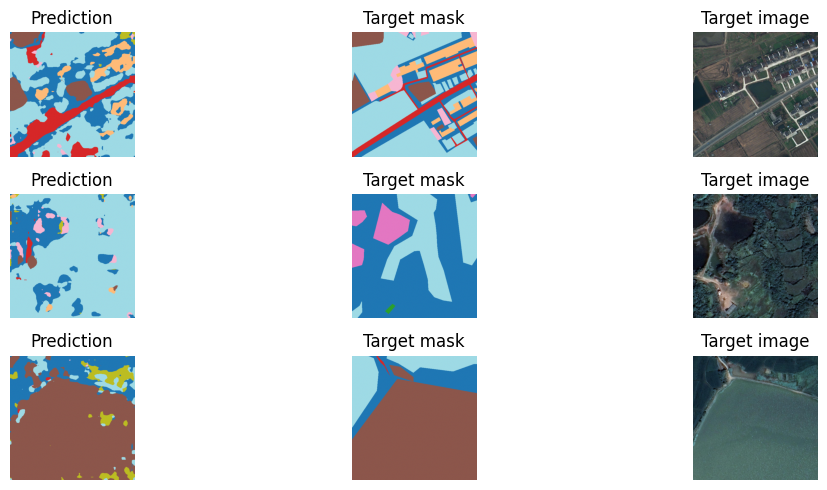

Epoch 20/20 | Validation Loss: 0.10626218371814297 | mIoU: 0.26859134435653687 | Total validation samples seen: 992
  → background IoU: 0.2893
  → building IoU: 0.3272
  → road IoU: 0.2199
  → water IoU: 0.5628
  → barren IoU: 0.1478
  → forest IoU: 0.0422
  → agriculture IoU: 0.2910


In [26]:
# ****************************** Validazione ******************************
from torchmetrics.segmentation import MeanIoU

num_classes = 7
miou_classes = MeanIoU(num_classes=num_classes, input_format = "index", per_class=True).to(device)

model.eval()
val_loss = 0
miou_classes.reset()
total_val_samples = 0

with torch.inference_mode():
    for batch, (X_val, y_val, boundary_mask) in enumerate(val_loader):
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        logits, *_ = model(X_val)

        if batch == 0:
          fig, axs = plt.subplots(3, 3, figsize=(12, 5))

          for j in range(3):
            axs[j, 0].imshow(logits[j].cpu().detach().argmax(dim=0).numpy(), cmap='tab20')
            axs[j, 0].set_title("Prediction")
            axs[j, 0].axis('off')

            axs[j, 1].imshow(y_val[j].cpu().detach().numpy(), cmap='tab20')
            axs[j, 1].set_title("Target mask")
            axs[j, 1].axis('off')

            axs[j, 2].imshow(X_val[j].cpu().detach().squeeze(0).numpy().transpose(1, 2, 0))
            axs[j, 2].set_title("Target image")
            axs[j, 2].axis('off')

          plt.tight_layout()
          plt.show()

        # Calcola la loss
        loss = loss_fn(logits, y_val)
        val_loss += loss.item()

        total_val_samples += X_val.size(0)

        # Calcola le predizioni
        preds = logits.argmax(dim=1)  # Shape: (N, H, W)

        # Mask dei pixel validi (classi da 0 a num_classes - 1)
        valid_mask = (y_val >= 0) & (y_val < num_classes)

        # print(f"valid mask :", valid_mask.shape )

        # Appiattisci le predizioni e i target solo sui pixel validi
        preds_flat = preds[valid_mask]
        targets_flat = y_val[valid_mask]

        # print(f"preds_flat :", preds_flat.shape )
        # print(f"targets_flat :", targets_flat.shape )

        miou_classes.update(preds_flat, targets_flat)

avg_val_loss = val_loss / total_val_samples

miou_per_class = miou_classes.compute()
miou = miou_per_class.mean()

print(f"Epoch {epoch+1}/{EPOCHS} | Validation Loss: {avg_val_loss} | mIoU: {miou} | Total validation samples seen: {total_val_samples}")
# per class
for i, iou in enumerate(miou_per_class):
    class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
    print(f"  → {class_name} IoU: {iou:.4f}")



## Evaluation

In [28]:
import torch

def load_inference_bisenet_model():
    """Returns the inference BISENET model, it has to be saved in `content/drive/MyDrive/AML_project/checkpoints/`."""

    model = BiSeNetV2(NUM_CLASSES, aux_mode='eval')
    try:
        saved_weights = torch.load(
            f"/content/drive/MyDrive/AML_project/checkpoints/model_BISENET_ADV.pth",
            map_location=torch.device("cpu")
        )
    except FileNotFoundError:
        raise ValueError("This model was not found")

    model.load_state_dict(saved_weights, strict=False)
    return model

### Salvataggio del modello su drive

In [29]:
model_path = f"/content/drive/MyDrive/AML_project/checkpoints/model_BISENET_ADV.pth"
torch.save(model.state_dict(), model_path)
print(f"Modello salvato: {model_path}")

model = load_inference_bisenet_model()
model.to(device)

Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/model_BISENET_ADV.pth


BiSeNetV2(
  (detail): DetailBranch(
    (S1): Sequential(
      (0): ConvBNReLU(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvBNReLU(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
    (S2): Sequential(
      (0): ConvBNReLU(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvBNReLU(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1

# Performance

FLOPs: 12.311 GFLOPs
Average inference latency is 0.010 seconds.


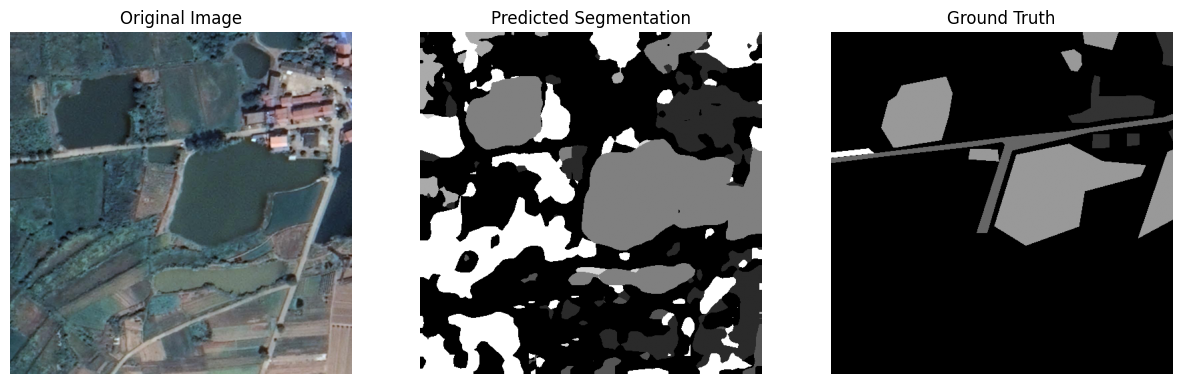

Params: 3.346 M


In [33]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import torch.nn.functional as F
import random

model.eval()  # Set model to evaluation mode

with torch.inference_mode():
    # Prendi un'immagine random dal validation set
    random_index = random.randint(0, len(val_dataset) - 1)
    X, y, boundary_mask = val_dataset[random_index]

    X = X.to(device).unsqueeze(dim=0)  # Aggiunge la dimensione batch
    y = y.to(device).unsqueeze(dim=0)
    boundary_mask = boundary_mask.to(device).unsqueeze(dim=0)

    start = timer()
    outputs = model(X)
    end = timer()

    outputs = outputs[0] if isinstance(outputs, tuple) else outputs

    latency = end - start


    # Calcolo dei FLOPs
    flops = FlopCountAnalysis(model, X.clone())

    # Softmax per normalizzare le predizioni
    normalized_masks = torch.nn.functional.softmax(outputs, dim=1)

    # Selezione delle predizioni per ciascuna classe
    masks = [
        normalized_masks[0, sem_class_to_idx[cls]]
        for cls in SEM_CLASSES
    ]

    print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")
    print(f"Average inference latency is {latency:.3f} seconds.")

    # Converti output e ground truth per la visualizzazione
    out = outputs.squeeze().argmax(dim=0).cpu().numpy()  # Output segmentazione
    y_np = y.squeeze().cpu().numpy()  # Ground truth
    X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()  # Immagine originale

    # Creazione della figura con tre immagini affiancate
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Immagine originale
    axes[0].imshow(X_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Predizione del modello
    axes[1].imshow(out, cmap="gray")
    axes[1].set_title("Predicted Segmentation")
    axes[1].axis("off")

    # Ground truth
    axes[2].imshow(y_np, cmap="gray")
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")

    plt.show()

    # Conta i parametri del modello
    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params / 1e6:.3f} M")
